# KZ NOTE:

    In this notebook I'll abadon numerical OMM-S8 labels but rather use 1,2,3,4, (different cosmology). Output_dim=1
    as the label. The compressed dv will be some smaller latent space representation in the last layer.

    Based on feed-back from Minsu. This works the best for NDE.
    

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d
from torchinfo import torchinfo

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16 #
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

In [6]:
# use only labels OMM, S8, w, A_IA, 

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



In [7]:
from sklearn.preprocessing import LabelEncoder

def create_label_mapping(labels, return_mapping=False):
    """
    Convert float labels to integer labels based on unique combinations of first two columns.
    
    Parameters:
    labels: numpy array of shape (N, 3) containing float labels
    return_mapping: bool, whether to return the mapping dictionary
    
    Returns:
    - integer_labels: numpy array of shape (N,) containing integer labels from 1 to num_unique
    - mapping: (optional) dictionary containing the mapping from float pairs to integers
    """
    # Extract first two columns and convert to strings for hashing
    # Round to handle floating point precision issues
    label_pairs = [f"{row[0]:.6f},{row[1]:.6f}" for row in labels]
    
    # Create label encoder
    le = LabelEncoder()
    integer_labels = le.fit_transform(label_pairs)
    
    # Add 1 to make labels start from 1 instead of 0
    integer_labels = integer_labels + 1
    
    if return_mapping:
        # Create mapping dictionary
        unique_pairs = le.classes_
        mapping = {pair: (idx + 1) for idx, pair in enumerate(unique_pairs)}
        
        # Convert string pairs back to float tuples in mapping
        float_mapping = {}
        for pair_str, idx in mapping.items():
            float1, float2 = map(float, pair_str.split(','))
            float_mapping[(float1, float2)] = idx
            
        return integer_labels, float_mapping
    
    return integer_labels

In [8]:
# Example usage

# Create sample data
np.random.seed(42)
n_samples = pars_train.shape[0]
n_unique = np.unique(pars_train[:,0]).shape[0]

labels = pars_train

# Convert to integer labels
int_labels, mapping = create_label_mapping(labels, return_mapping=True)

# Print some statistics
print(f"Original shape: {labels.shape}")
print(f"Number of unique integer labels: {len(set(int_labels))}")
print(f"Integer label range: {int_labels.min()} to {int_labels.max()}")

# Print first few mappings
print("\nFirst few mappings (float_pair -> integer):")
for i, (pair, integer) in enumerate(sorted(mapping.items())[:5]):
    print(f"{pair} -> {integer}")

# Verify we can recover original pairs
reverse_mapping = {v: k for k, v in mapping.items()}
print("\nReverse mapping example:")
example_label = int_labels[0]
original_pair = reverse_mapping[example_label]
print(f"Integer label {example_label} maps to pair {original_pair}")

Original shape: (9124, 3)
Number of unique integer labels: 766
Integer label range: 1 to 766

First few mappings (float_pair -> integer):
(0.1273, 0.544838) -> 1
(0.1424, 0.73271) -> 2
(0.144524, 0.804118) -> 3
(0.146993, 0.777416) -> 4
(0.1484, 0.632923) -> 5

Reverse mapping example:
Integer label 296 maps to pair (0.2915, 0.772321)


In [30]:
# transform the test(LFI) set (for plotting purposes later)
tmp_pairs = [f"{row[0]:.6f},{row[1]:.6f}" for row in pars_LFI]

paras_LFI_int_label = np.zeros((pars_LFI.shape[0], 1))
for ii in range(pars_LFI.shape[0]):

    float1, float2 = map(float, tmp_pairs[ii].split(','))
    paras_LFI_int_label[ii] = mapping[float1, float2]

In [33]:
# some test

tmp = np.unique(pars_train[:,0])
print(np.where(pars_train[:,0]==tmp[2]))

print(paras_LFI_int_label.shape)

print('testing')
print(int_labels[2313], int_labels[3674], int_labels[5504], int_labels[8599])

(array([2313, 3674, 4955, 5242, 5340, 5504, 6472, 6528, 6734, 7080, 7456,
       8599]),)
(8187, 1)
testing
3 3 3 3


# Process data; with ZCA whitening

In [12]:
from compression_nn.preprocess import MinMaxNormalizer

In [13]:
print('Train with all 16 parameters.')

print('max-min normalize the labels')

# Initialize and fit normalizer
label_normalizer = MinMaxNormalizer()
pars_train = label_normalizer.fit_transform(int_labels)
pars_train = pars_train.reshape(-1,1)

Train with all 16 parameters.
max-min normalize the labels


In [14]:
# test
pars_train[2313], pars_train[3674]

(array([0.00261438]), array([0.00261438]))

In [37]:
num_samples = len(pars_train)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices],
    train_y=pars_train[train_indices],
    val_x=dv[val_indices],
    val_y=pars_train[val_indices],
    test_x=dv_LFI,
    test_y=paras_LFI_int_label, #pars_LFI,
    batch_size=BATCH_SIZE,
    whitening=True
)

# Start Training!

In [16]:
hyperparameter_configs = [
    {
        'test_id': 'semi_ae_class_label_v1',
        'hidden_dims': [64, 32, 16],
        'dropout_rate': 0.1
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.ReLU(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=50,
        loss_fun = torch.nn.L1Loss()
    )

# plot validations


In [47]:
def plot_test_error_all_param_TEST(model, test_loader, n_params, label_normalizer=None, device='cuda', output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=range(n_params)

    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    points = 0

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    # model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            if x.dtype == torch.float64:
                x = x.float()
            x     = x.to(device)       #send data to device
            y     = y.to(device)  #send data to device
            p     = model.predict(x)           #prediction for mean and variance
            y_NN  = p           #prediction for mean

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            if isinstance(y_NN, torch.Tensor):
                y_NN = y_NN.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN

            points    += x.shape[0]
            
    # inverse-normalization if needed
    if label_normalizer is not None:
        params_NN   = label_normalizer.inverse_transform(params_NN)

    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])


    # KZ: let me first assume n_params is even 
    f, axarr = plt.subplots(1, 1, figsize=(6,6))
    
    for i in range(n_params):
        # if i%2==0:
        row_idx = i
        print('test', i)
        axarr.plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

        axarr.plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
        axarr.set_xlabel(r"True param "+str(i))
        axarr.set_ylabel(r"Predicted param "+ str(i))

        axarr.text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr.transAxes)
        axarr.text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr.transAxes)

#         else:
#             row_idx = i//2
            
#             axarr[row_idx,1].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

#             axarr[row_idx,1].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
#             axarr[row_idx,1].set_xlabel(r"True param "+str(i))
#             axarr[row_idx,1].set_ylabel(r"Predicted param "+ str(i))

#             axarr[row_idx,1].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
#             axarr[row_idx,1].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
            
    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

 RMSE = 98.060
 $R^2$ = 0.816
Error S_8 = 35.066
test 0


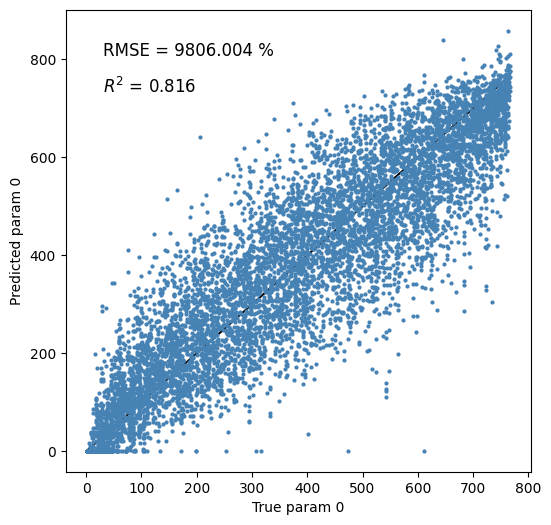

In [48]:
loaded_model = CompressionNN.load('semi_ae_class_label_v1')
loaded_model.model.to('cpu')

plot_test_error_all_param_TEST(loaded_model, test_loader, n_params=1, label_normalizer=label_normalizer, device='cpu', output=False)


In [50]:
test_full_dv = test_loader.dataset.tensors[0]
print(test_full_dv.shape)

torch.Size([8187, 608])


In [51]:
compressed_dv_semi_ae = loaded_model.get_last_hidden_layer(test_full_dv)


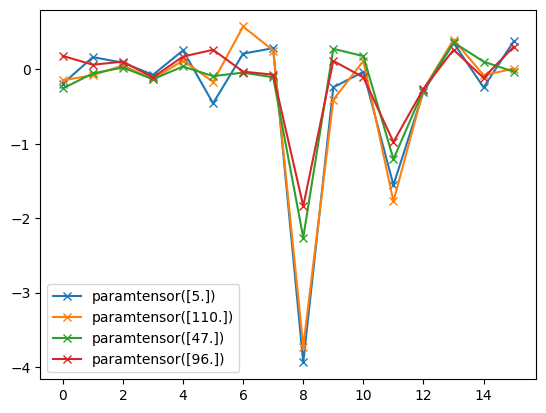

In [53]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]

dv_compressed_fid = loaded_model.predict(dv_set_fid)
dv_compressed_fid = label_normalizer.inverse_transform(dv_compressed_fid)

In [54]:
dv_compressed_fid_ae = loaded_model.get_last_hidden_layer(dv_set_fid)
dv_compressed_fid_ae = np.mean(dv_compressed_fid_ae,axis=0)

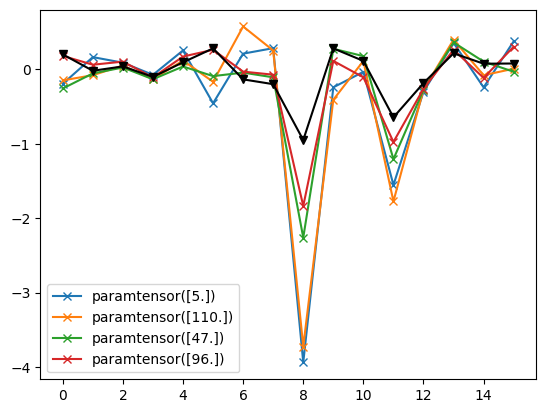

In [58]:
for i in [1,5,200,100]:
    plt.plot(compressed_dv_semi_ae[i], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
    
plt.plot(dv_compressed_fid_ae,'v-', c='black', )
plt.legend()

In [55]:
compressed_dv_semi_ae.shape, dv_compressed_fid_ae.shape

((8187, 16), (16,))

In [56]:
np.save('./output/compressed_dv_semi_ae_d16_intlabel', compressed_dv_semi_ae)
np.save('./output/dv_compressed_fid_ae_d16_intlabel', dv_compressed_fid_ae)